# Fitting BERT Classifier to Twitter MBTI

In [ ]:
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve

In [ ]:
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: TITAN X (Pascal)


In [ ]:
def expand_frame(df, length):
    ndf = pd.DataFrame()

    for i in range(1,30):
        adf = df.copy(deep= True)
        adf['text'] = adf['text'].apply(lambda x: x[0 + length*5*i : length * 5 * (i+1)])
        ndf = ndf.append(adf)
        ndf.reset_index(drop=True, inplace= True)
    return ndf



# Loading the Twitter personality dataset:

# OPTION 1 : Load raw without tokenized:

In [ ]:
ofile = open('Data/personality_likes_large.csv', encoding = 'cp1252', mode='r' )
raw_df = pd.read_csv(ofile ,index_col=0)
ofile.close()

In [ ]:
wifile = open('train_tokenized_large_exp.csv', mode = 'w+')
wtfile = open('test_tokenized_large_exp.csv', mode = 'w+')

wifile.truncate(0)
wtfile.truncate(0)

0

In [ ]:
train_df, test_df = train_test_split(raw_df, stratify = raw_df['type'], random_state= 1729, test_size= 0.12)

In [ ]:
train_df = expand_frame(train_df, 256)

train_df.dropna(inplace = True)
test_df.to_csv(wtfile)

wtfile.close()


In [ ]:
# Create sentence and label lists
sentences = train_df.text.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]

'[CLS] 7 @brad_polumbo @mattyglesias Not just can but can\'t create money out of anything else@MyPillowUSA what’s good?@leftwinggal Nobody is marginalizing Dutch-Americans what the fuckhttps://t.co/OQTASiMt5u@AndrewYang https://t.co/HfvynOpeHu@AndrewYang https://t.co/suSZXLoK2QSo basically, only rich while men can try to make a $, the rest of you are not worthy. OK.  https://t.co/CrQ6q9i40YWho’s this Fucking Guy... $GME $AMC to the  MOON  https://t.co/KUmZPWdO9l@reddittrading I have a romantic relationship with my $AMC stock.Baptist leaders: "Only men can be in leadership positions, so they can use their strength to protect women."\n\nAlso Baptist leaders: "I\'m sorry, I can\'t do anything substantial to help sexual abuse victims because other men might say mean things about me."\n\nA plague of cowards.Democratic leadership laying down the gauntlet on Marjorie Taylor Greene: Steny Hoyer is expected to tell Kevin McCarthy he has 72 hours to strip Marjorie Taylor Greene of her committee 

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

train_df['tokenized_texts'] = tokenized_texts

Tokenize the first sentence:
['[CLS]', '@', 'mig', '##non', '##10', '##44', '@', 'mig', '##non', '##10', '##44', '!', '!', '@', 'mig', '##non', '##10', '##44', '@', 'mig', '##non', '##10', '##44', '?', '@', 'mig', '##non', '##10', '##44', '@', 'mig', '##non', '##10', '##44', '.', '.', '.', '.', '@', 'mig', '##non', '##10', '##44', '@', 'mig', '##non', '##10', '##44', '~', '~', '~', '@', 'mig', '##non', '##10', '##44', '.', '.', '[SEP]']


In [ ]:
train_df.to_csv(wifile)

In [ ]:
wifile.close()
ofile = open('train_tokenized_large_exp.csv',  mode='r' )
edf = pd.read_csv(ofile, index_col = 0)

,liked_by,text,type,extravert,intuitive,thinking,judging,NT,SF,NF,ST,NJ,NP,SJ,SP,tokenized_texts
0,1281267858639486976,@mignon1044 @mignon1044 !!@mignon1044 @migno...,ISTJ,0,0,1,1,0,0,0,1,0,0,1,0,"['[CLS]', '@', 'mig', '##non', '##10', '##44',..."
1,17724827,an sebegitu menyebabkan anda cuba mengganggu d...,INFJ,0,1,0,1,0,0,1,0,1,0,0,0,"['[CLS]', 'an', 'se', '##be', '##git', '##u', ..."
2,84772941,that I can use strong language.the news: stay...,ENFP,1,1,0,0,0,0,1,0,0,1,0,0,"['[CLS]', 'that', 'i', 'can', 'use', 'strong',..."
3,3416461845,s://t.co/JZXYOUsCqoSelena Gomez's Makeup Artis...,ESFP,1,0,0,0,0,1,0,0,0,0,0,1,"['[CLS]', 's', ':', '/', '/', 't', '.', 'co', ..."
4,3075434919,"de papai, queria eu ser, único erro dele foi r...",ESFP,1,0,0,0,0,1,0,0,0,0,0,1,"['[CLS]', 'de', 'papa', '##i', ',', 'que', '##..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106802,2356621515,NaN,ESFP,1,0,0,0,0,1,0,0,0,0,0,1,"['[CLS]', '[SEP]']"
106803,706889633670557697,NaN,INFJ,0,1,0,1,0,0,1,0,1,0,0,0,"['[CLS]', '[SEP]']"
106804,91546751,@LiviaBellona @TheKimClub @PharmDame @PeterFMa...,ENFJ,1,1,0,1,0,0,1,0,1,0,0,0,"['[CLS]', '@', 'liv', '##ia', '##bell', '##ona..."
106805,24946566,questioned my non-linear liberal arts path. ht...,INTJ,0,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'questioned', 'my', 'non', '-', 'lin..."


# OPTION 2: Load Dataframe from disk

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
test_file = open('test_tokenized_large_exp.csv')
ofile = open('train_tokenized_large_exp.csv')

edf = pd.read_csv(ofile, index_col = 0)

edf.dropna(inplace= True)
#edf, test_df = train_test_split(edf, random_state=2020, test_size=0.10)
test_df = pd.read_csv(test_file, index_col=0)

In [ ]:
test_df = test_df.reset_index(drop = True)

In [ ]:
def fourType(x):
    if ((x=='INFJ') | (x=='INFP') | (x=='ENFJ') | (x=='ENFP')):
        return 1
    elif ((x=='INTJ') | (x=='INTP') | (x=='ENTJ') | (x=='ENTP')):
        return 2
    elif ((x=='ISFJ') | (x=='ISTJ') | (x=='ESFJ') | (x=='ESTJ')):
        return 3
    else:
        return 0

In [ ]:
edf['role'] = edf['type'].map(fourType)
test_df['role'] = test_df['type'].map(fourType)

In [ ]:
df = edf[edf['role']==1].sample(10808, random_state = 34)
df = df.append(edf[edf['role']==2].sample(10808, random_state = 35))
df = df.append(edf[edf['role']==3].sample(10808, random_state = 35))
df = df.append(edf[edf['role']==0].sample(10808, random_state = 35))

,liked_by,text,type,extravert,intuitive,thinking,judging,NT,SF,NF,ST,NJ,NP,SJ,SP,tokenized_texts,role
105039,15620292,rUryJJaqPnokay I know you guys like TTRPGs. h...,INFP,0,1,0,0,0,0,1,0,0,1,0,0,"['[CLS]', 'ru', '##ry', '##j', '##ja', '##q', ...",1
52013,3403218160,CiBSdFW2vSreal pokemon merchandise https://t.c...,INFP,0,1,0,0,0,0,1,0,0,1,0,0,"['[CLS]', 'ci', '##bs', '##df', '##w', '##2', ...",1
57263,1244901512700030976,it out for Free (link in bio)\n#brunette #curl...,INFJ,0,1,0,1,0,0,1,0,1,0,0,0,"['[CLS]', 'it', 'out', 'for', 'free', '(', 'li...",1
71092,26871926,l me anh(at)https://t.co/Leb3wLQo3x.We just wa...,ENFJ,1,1,0,1,0,0,1,0,1,0,0,0,"['[CLS]', 'l', 'me', 'an', '##h', '(', 'at', '...",1
96461,6046132,ng it. Anyway the commercially-successful-but-...,INFP,0,1,0,0,0,0,1,0,0,1,0,0,"['[CLS]', 'ng', 'it', '.', 'anyway', 'the', 'c...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22249,172118801,MUNICADO https://t.co/QTXWaFw6Oyhttps://t.co/A...,ESFP,1,0,0,0,0,1,0,0,0,0,0,1,"['[CLS]', 'mu', '##nica', '##do', 'https', ':'...",0
58010,491669361,me ambassador for @worldvisioncan. Now we know...,ESFP,1,0,0,0,0,1,0,0,0,0,0,1,"['[CLS]', 'me', 'ambassador', 'for', '@', 'wor...",0
78902,26541394,the developers specifically had CRT monitors i...,ISTP,0,0,1,0,0,0,0,1,0,0,0,1,"['[CLS]', 'the', 'developers', 'specifically',...",0
9532,790271395855003649,ed before my brains melt. #jiroukyouka #jiro ...,ISFP,0,0,0,0,0,1,0,0,0,0,0,1,"['[CLS]', 'ed', 'before', 'my', 'brains', 'mel...",0


In [ ]:
from ast import literal_eval

df = df.sample(frac=1).reset_index(drop=True)
tokenized_texts = df['tokenized_texts'].map(literal_eval)

test_df = test_df.reset_index(drop = True)

In [ ]:
tokenized_texts

0        [[CLS], er, ##y, despite, l, ##w, ##j, ', s, w...
1        [[CLS], ph, #, gu, ##hit, ##pina, ##s, https, ...
2        [[CLS], h, eli, ##mina, ##das, da, pro, ##va, ...
3        [[CLS], p, ;, se, ##m, o, bo, ##a, no, ##ite, ...
4        [[CLS], for, an, interview, with, @, maggie, _...
                               ...                        
43227    [[CLS], https, :, /, /, t, ., co, /, ct, ##ek,...
43228    [[CLS], yang, ku, ##rang, pen, ##ting, ., http...
43229    [[CLS], tis, i, ’, ve, never, had, a, pizza, w...
43230    [[CLS], r, lists, !, !, !, !, thank, you, all,...
43231    [[CLS], s, :, /, /, t, ., co, /, f, ##s, ##x, ...
Name: tokenized_texts, Length: 43232, dtype: object

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 256

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Pad our input tokens
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
input_ids

array([[  101,  9413,  2100, ...,  2860,  3501,  5176],
       [  101,  6887,  1001, ..., 16770,  1024,  1013],
       [  101,  1044, 12005, ...,  4487,  1012,  1001],
       ...,
       [  101, 22320,  1045, ...,  1996, 11675,  1012],
       [  101,  1054,  7201, ...,  2000,  2079,  2007],
       [  101,  1055,  1024, ..., 18351,  5622,  2912]])

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

labels = df.role.values
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.01)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.01)

# **OPTION 3: Load v2 Dataframe from disk**

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.3MB 6.0MB/s 
     |████████████████████████████████| 3.3MB 48.0MB/s 
     |████████████████████████████████| 901kB 56.6MB/s 


In [ ]:
import ast 
import sklearn
import pandas as pd
import transformers
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from ast import literal_eval

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def from_np_array(array_string):
    array_string = ','.join(array_string.replace('[ ', '[').split())
    return np.array(ast.literal_eval(array_string))

In [ ]:
folder_path = '/content/drive/MyDrive/MBTI_DL_Data/'
ofile = open(folder_path + 'Dataframes/master_v2.3.csv', mode = 'r', encoding= 'windows-1252')

df = pd.read_pickle(folder_path + 'Dataframes/master_v2.3.csv' )
df

,extravert,follow_back_pic_urls,follow_bios,follow_follows_counts,follow_profile_pic_urls,follow_stats_counts,intuitive,judging,lang,liked_media,liked_tweets,own_media,statuses,thinking,type,user_id,screen_name,name,bio,favorites_count:,statuses_count,follows_count,profile_back_url,profile_pic_url,queried_at,profile_embedding_resnet50,image_array
0,0.0,['http://abs.twimg.com/images/themes/theme1/bg...,['Leader; follower. Reader; writer. Speaker; l...,"[118, 1055, 3, 1989, 69, 335, 654, 980, 98, 39...",['http://pbs.twimg.com/profile_images/64760639...,"[87848, 3561, 1468, 54864, 276, 5255, 116451, ...",1.0,0.0,und,['https://pbs.twimg.com/media/Em-45V2VkAAUJqY....,['@M40A3Predator hope you been well. Miss you ...,['https://pbs.twimg.com/media/D4dqPJLVUAAo3Fk....,"['https://t.co/lkHBulmhvc', 'We evolved the ap...",1.0,INTP,104066691,M40A3Predator,Logan Keesling,College student. INTP.,1650,6669,400,http://abs.twimg.com/images/themes/theme9/bg.gif,http://pbs.twimg.com/profile_images/1031267728...,2021-05-08 00:08:50.658936,"[0.04489563778042793, 2.174224615097046, 0.499...","[[[12, 19, 25], [12, 19, 25], [12, 19, 25], [1..."
1,0.0,['http://abs.twimg.com/images/themes/theme1/bg...,['Making people proud to care about gun rights...,"[67, 414, 1024, 62, 1, 68, 1703, 681, 85, 4030...",['http://pbs.twimg.com/profile_images/10861406...,"[2670, 3487, 30848, 5435, 1229, 10775, 3189, 2...",1.0,0.0,en,['https://pbs.twimg.com/media/E0Aq-wPXIAYhM28....,"[""@hackaday It was 1989. Someone changed the r...",[],"[""So USA has too many #COVID19 vaccines, while...",1.0,INTP,728747154,LukeDashjr,Luke Dashjr,"Roman #Catholic*, husband, father of 7 childre...",32648,58883,139,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1299396704...,2021-05-08 00:08:50.671926,"[0.4525538980960846, 0.24154025316238403, 0.82...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,0.0,['http://abs.twimg.com/images/themes/theme9/bg...,['#FreeMarket think tank advancing real soluti...,"[14892, 31, 1456, 2244, 874, 11342, 11, 71, 14...",['http://pbs.twimg.com/profile_images/13777942...,"[67741, 858, 59783, 89244, 9986, 10429, 136, 2...",1.0,0.0,en,['https://pbs.twimg.com/media/E0DO_ihWEAANspm....,"[""Patch V1.3.0\n\nWe've been listening, and we...",['https://pbs.twimg.com/media/EzTmWO8UUAE-cK-....,"['Life isn\'t fair.\n\nThat\'s not a lament, t...",1.0,INTP,321645158,Sacheverell,Sacheverell,Trust & Safety Lead @vrchat. | Formerly T&S @w...,32461,46164,1274,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9959137055...,2021-05-08 00:08:50.678938,"[0.8381090760231018, 1.453566312789917, 0.1410...","[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,0.0,"[None, None, 'http://abs.twimg.com/images/them...",['NAME will be announced closer to launch - HE...,"[1, 1376, 6122, 601, 1299, 690, 785, 340, 1079...",['http://pbs.twimg.com/profile_images/13842164...,"[6, 8753, 9855, 13930, 36826, 131, 2888, 9751,...",1.0,0.0,en,['https://pbs.twimg.com/amplify_video_thumb/12...,['It’s The Oscars tonight! I wasn’t invited. W...,['https://pbs.twimg.com/ext_tw_video_thumb/138...,"['Happy puppies 🥺🥰 https://t.co/O6FOXQQFtF', '...",1.0,INTP,346419306,Blondiettv,Shan,tired. | @Twitch Partner |,24435,24809,1092,http://abs.twimg.com/images/themes/theme19/bg.gif,http://pbs.twimg.com/profile_images/1377152197...,2021-05-08 00:08:50.688448,"[0.05482032522559166, 1.4306827783584595, 0.58...","[[[189, 185, 173], [189, 185, 173], [189, 185,..."
4,0.0,"[None, 'http://abs.twimg.com/images/themes/the...",['Occasional funny clips from games I recorded...,"[2, 687, 37, 408, 360, 765, 975, 239, 360, 492...",['http://pbs.twimg.com/profile_images/13360189...,"[2, 0, 6557, 1348, 2898, 6999, 37687, 1219, 89...",1.0,0.0,en,['https://pbs.twimg.com/media/EwkPYfNVIAQU7Vs....,"['""Oh I\'m not very good at that game, but sur...",['https://pbs.twimg.com/media/Ew4wixCW8AEBwCn....,['long time no see\nI started a new job last w...,1.0,INTP,709345

In [ ]:
adf = df[['extravert', 'thinking', 'intuitive', 'judging', 'lang', 'liked_tweets']]

In [ ]:
adf['liked_tweets']


0       ['@M40A3Predator hope you been well. Miss you ...
1       ["@hackaday It was 1989. Someone changed the r...
2       ["Patch V1.3.0\n\nWe've been listening, and we...
3       ['It’s The Oscars tonight! I wasn’t invited. W...
4       ['"Oh I\'m not very good at that game, but sur...
                              ...                        
3843    ['BUTTER // @BTS_twt // MAY 21\n\nPRE-SAVE/PRE...
3844    ['@moh_q6 اهليين كارلوس🥺💜', '@moh_q6 ههههههههه...
3845    ['One punny anti-Trump sign spotted in London ...
3846    ['🚨 2020 found dead in electrical\n\nready for...
3847    ['@ArthurMcvicious @petalsforlau @xvikkisx doi...
Name: liked_tweets, Length: 3848, dtype: object

In [ ]:
def trim_liked(x):
  r = ''
  s = x.split()
  for word in s:
    if (len(word)<20) and (word[0] != '@'):
      r+= ' ' + word
      
  return r

In [4]:
adf['liked_tweets'] = adf['liked_tweets'].apply(lambda x: '. '.join(ast.literal_eval(x)))
adf['liked_tweets'] = adf['liked_tweets'].apply(lambda x: trim_liked(x))

NameError: ignored

In [2]:
adf

NameError: ignored

In [3]:
target_mode = 'intuitive'

sample_size = min(len(adf[adf[target_mode]==1]), len(adf[adf[target_mode]==0] ))

typeA = adf[adf[target_mode]==1].sample(sample_size)
typeB = adf[adf[target_mode]==0].sample(sample_size)
sample_size

NameError: ignored

In [5]:
data_A = typeA[['liked_tweets', target_mode]]
data_B = typeB[['liked_tweets', target_mode]]

data_df = data_A.append(data_B).sample(frac = 1, random_state = 42).reset_index(drop = True)

train_df, test_df = train_test_split(data_df, random_state= 1729, test_size= 0.10)

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)

NameError: ignored

In [ ]:
train_df

,liked_tweets,intuitive
0,Thanks to for sharing this inspiring message....,1.0
1,2018 / 2021 top personagens chatos de dorama ...,0.0
2,拍了几十遍！ 长图 请 女孩子们 一定不要 两个人住酒店 也不要一个人单独住酒店。 Cai...,0.0
3,"I am heartbroken to announce that my Dad, my ...",0.0
4,Good morning everyone from me and my ...........,1.0
...,...,...
2819,"Stayed tuned for client announcements, illust...",1.0
2820,Open your mind... Danchou has been working ou...,1.0
2821,There’s a lot of people who have absolutely n...,1.0
2822,ส่งหน่วย seal เข้าไปละฮะ รอดูผล 5555. อดีตหุ้...,0.0


In [ ]:
test_df

,liked_tweets,intuitive
0,I am 30 minutes into home schooling my 6 year...,0.0
1,1/ I'm in the middle of a skincare deep dive ...,1.0
2,Can’t wait to chat with you on my Onlyfans! 💋...,0.0
3,eu. mas esse não é o papel de qualquer ator? ...,0.0
4,I BEAT Stage 3 Colon Cancer in the middle of ...,1.0
...,...,...
309,This is the best thing in my day.. LOL! Pee i...,0.0
310,mood removing ram from a computer while it’s ...,1.0
311,Here's some snaps of some of my favorite stre...,1.0
312,Become ungovernable Lizzo is so gorgeous omg ...,1.0


In [ ]:
def expand_frame(df, length):
    ndf = pd.DataFrame()
    cdf = df.copy(deep= True)
    cdf['split_tweets'] = cdf['liked_tweets'].apply(lambda x: x.split())
    print('1')
    for i in range(0, 21):
        ccdf = cdf[cdf['split_tweets'].apply(lambda x: (len(x) > (0 + i * length)) == 1)]
        ccdf['split_tweets'] = ccdf['split_tweets'].apply(lambda x: x[0 + length*i : length * (i+1)])
        ndf = ndf.append(ccdf)  
        ndf.reset_index(drop=True, inplace= True)                                     

    print('1') 
    ndf['liked_tweets'] = ndf['split_tweets'].apply(lambda x: ' '.join(x))
    return ndf

In [ ]:
train_df = expand_frame(train_df, 512)
train_df = train_df.sample(frac = 1, random_state= 153)
train_df.reset_index(inplace= True, drop = True)
train_df

1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


1


,liked_tweets,intuitive,split_tweets
0,"your happiness, and sad for your sadness. They...",0.0,"[your, happiness,, and, sad, for, your, sadnes..."
1,to have start-up like this from India.. Thank ...,1.0,"[to, have, start-up, like, this, from, India....."
2,morro de medo de não conseguir trabalho nem na...,1.0,"[morro, de, medo, de, não, conseguir, trabalho..."
3,"it's my best book yet.. Cause, attacking someo...",1.0,"[it's, my, best, book, yet.., Cause,, attackin..."
4,Yo respondiendo los mensajes de mis amigos des...,0.0,"[Yo, respondiendo, los, mensajes, de, mis, ami..."
...,...,...,...
32851,give to others. No matter how his appearance c...,0.0,"[give, to, others., No, matter, how, his, appe..."
32852,Connecticut to register to join Sustainable CT...,0.0,"[Connecticut, to, register, to, join, Sustaina..."
32853,me 🦦 buying a set when i get paid this week so...,1.0,"[me, 🦦, buying, a, set, when, i, get, paid, th..."
32854,food but … books? Feels like the pandemic fast...,1.0,"[food, but, …, books?, Feels, like, the, pande..."


In [ ]:
train_df

,liked_tweets,intuitive,split_tweets
0,"your happiness, and sad for your sadness. They...",0.0,"[your, happiness,, and, sad, for, your, sadnes..."
1,to have start-up like this from India.. Thank ...,1.0,"[to, have, start-up, like, this, from, India....."
2,morro de medo de não conseguir trabalho nem na...,1.0,"[morro, de, medo, de, não, conseguir, trabalho..."
3,"it's my best book yet.. Cause, attacking someo...",1.0,"[it's, my, best, book, yet.., Cause,, attackin..."
4,Yo respondiendo los mensajes de mis amigos des...,0.0,"[Yo, respondiendo, los, mensajes, de, mis, ami..."
...,...,...,...
32851,give to others. No matter how his appearance c...,0.0,"[give, to, others., No, matter, how, his, appe..."
32852,Connecticut to register to join Sustainable CT...,0.0,"[Connecticut, to, register, to, join, Sustaina..."
32853,me 🦦 buying a set when i get paid this week so...,1.0,"[me, 🦦, buying, a, set, when, i, get, paid, th..."
32854,food but … books? Feels like the pandemic fast...,1.0,"[food, but, …, books?, Feels, like, the, pande..."


In [ ]:
test_df

,liked_tweets,intuitive
0,I am 30 minutes into home schooling my 6 year...,0.0
1,1/ I'm in the middle of a skincare deep dive ...,1.0
2,Can’t wait to chat with you on my Onlyfans! 💋...,0.0
3,eu. mas esse não é o papel de qualquer ator? ...,0.0
4,I BEAT Stage 3 Colon Cancer in the middle of ...,1.0
...,...,...
309,This is the best thing in my day.. LOL! Pee i...,0.0
310,mood removing ram from a computer while it’s ...,1.0
311,Here's some snaps of some of my favorite stre...,1.0
312,Become ungovernable Lizzo is so gorgeous omg ...,1.0


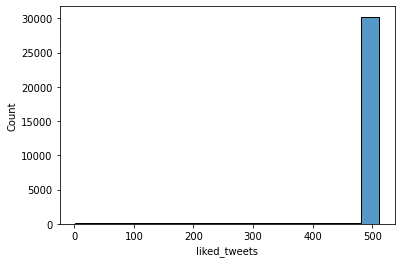

In [ ]:
import seaborn as sns

sns.histplot(train_df['liked_tweets'].apply(lambda x: len(x.split())))

In [ ]:
# Create sentence and label lists
sentences = train_df.liked_tweets.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = train_df.intuitive.values

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])


Tokenize the first sentence:
['[CLS]', 'your', 'happiness', ',', 'and', 'sad', 'for', 'your', 'sadness', '.', 'they', '’', 're', 'the', 'ones', 'who', 'deserve', 'special', 'places', 'in', 'your', 'heart', '.', '”', 'finally', 'got', 'his', 'own', 'room', '!', 'se', '##jak', '5', 'hari', 'y', '##g', 'lal', '##u', ',', 'rider', 'shop', '##ee', 'express', 'di', 'da', '##era', '##h', 'ja', '##bo', '##de', '##ta', '##bek', 'mel', '##ak', '##uka', '##n', 'mo', '##go', '##k', 'ke', '##r', '##ja', '.', 'mere', '##ka', 'pro', '##tes', 'karen', '##a', 'up', '##ah', '##nya', 'di', '##tur', '##unk', '##an', 'dar', '##i', '5', '.', '000', '/', 'pak', '##et', ',', '3', '.', '500', '/', 'pak', '##et', ',', '2', '.', '500', '/', 'pak', '##et', ',', '&', 'amp', ';', 'pad', '##a', 'aw', '##al', 'april', 'men', '##jad', '##i', '1', '.', '500', '/', 'pak', '##et', '.', 'mere', '##ka', 'tak', 'da', '##pa', '##t', 'up', '##ah', 'minimum', '&', 'amp', ';', 'jam', '##ina', '##n', 'so', '##sia', '##l', '.', 

In [ ]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 512

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [ ]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2020, test_size=0.01)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2020, test_size=0.01)

# BERT

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 8

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
import random
torch.cuda.empty_cache()
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 44

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        b_labels = torch.nn.functional.one_hot(b_labels.to(torch.int64), num_classes=2)

        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels.to(torch.float64))
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        loss = loss.mean()
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  4,066.    Elapsed: 0:00:18.
  Batch    80  of  4,066.    Elapsed: 0:00:36.
  Batch   120  of  4,066.    Elapsed: 0:00:54.
  Batch   160  of  4,066.    Elapsed: 0:01:12.
  Batch   200  of  4,066.    Elapsed: 0:01:30.
  Batch   240  of  4,066.    Elapsed: 0:01:48.
  Batch   280  of  4,066.    Elapsed: 0:02:06.
  Batch   320  of  4,066.    Elapsed: 0:02:24.
  Batch   360  of  4,066.    Elapsed: 0:02:42.
  Batch   400  of  4,066.    Elapsed: 0:03:00.
  Batch   440  of  4,066.    Elapsed: 0:03:18.
  Batch   480  of  4,066.    Elapsed: 0:03:36.
  Batch   520  of  4,066.    Elapsed: 0:03:54.
  Batch   560  of  4,066.    Elapsed: 0:04:12.
  Batch   600  of  4,066.    Elapsed: 0:04:30.
  Batch   640  of  4,066.    Elapsed: 0:04:48.
  Batch   680  of  4,066.    Elapsed: 0:05:06.
  Batch   720  of  4,066.    Elapsed: 0:05:24.
  Batch   760  of  4,066.    Elapsed: 0:05:42.
  Batch   800  of  4,066.    Elapsed: 0:06:00.
  Batch   840  of

# Testing

## Helper function for predicting whether label matches the person's prediction, for one person:

In [ ]:
import statistics

def predict_person(text, label, length):
  #  print(len(text))
    
    split_text = text.split()
  #  print('split_text: ', len(split_text))
    sentences = []
    for i in range(0, int(len(split_text)/length)+1):
      sentences.append(' '.join(split_text[0 + i*length : (i+1) * length]))
  #  print('sentences: ', len(sentences))
    labels = [label] * len(sentences)
  #  print(len(labels))
   # print(len(sentences))
    input_ids = []
    for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )

        input_ids.append(encoded_sent)

    input_ids = pad_sequences(input_ids, maxlen=MAX_LEN,
                          dtype="long", truncating="post", padding="post")

    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)

    # Convert to tensors.
    prediction_inputs = torch.tensor(input_ids)
    prediction_masks = torch.tensor(attention_masks)
    prediction_labels = torch.tensor(labels)
    # Set the batch size.
    batch_size = 32

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

  #  print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables
    predictions , true_labels = [], []

    # Predict
    for batch in prediction_dataloader:
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
        with torch.no_grad():
           # Forward pass, calculate logit predictions
           outputs = model(b_input_ids, token_type_ids=None,
                      attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    #for i in range(len(true_labels)):

    # The predictions for this batch are a 2-column ndarray (one column for "0"
    # and one column for "1"). Pick the label with the highest value and turn this
    # in to a list of 0s and 1s.
    correct = 0
    num = 0

    final_predict_list = []

    for i in range(len(true_labels)):

        pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
        [final_predict_list.append(i) for i in pred_labels_i]
       # if accuracy_score(pred_labels_i, [0] * len(pred_labels_i)) < 0.5 :
        #    correct += 1
       # num+=1
  #  print('list: ', final_predict_list)
  #  print(label)
    try: 
       if (statistics.mode(final_predict_list)==label):
          return 1
       else:
          return 0
    except:
       return random.randint(0,1)
    






## Final predictive accuracy score:

In [ ]:
test_df

,liked_tweets,intuitive
0,I am 30 minutes into home schooling my 6 year...,0.0
1,1/ I'm in the middle of a skincare deep dive ...,1.0
2,Can’t wait to chat with you on my Onlyfans! 💋...,0.0
3,eu. mas esse não é o papel de qualquer ator? ...,0.0
4,I BEAT Stage 3 Colon Cancer in the middle of ...,1.0
...,...,...
309,This is the best thing in my day.. LOL! Pee i...,0.0
310,mood removing ram from a computer while it’s ...,1.0
311,Here's some snaps of some of my favorite stre...,1.0
312,Become ungovernable Lizzo is so gorgeous omg ...,1.0


In [ ]:
correct = 0
num = 0
for row in tqdm(range(0, len(test_df.index)), "testing.."):
    
    pred_text = test_df.at[row, 'liked_tweets']
    
    pred_label = test_df.at[row, target_mode]
    if pred_label == 0:
      #print('Skipped')
      continue    
    num+=1
    pred = predict_person(pred_text, pred_label, 512)
   # print(pred)
    if pred == 1:
        correct+=1

print("ACC: ", correct/num)

In [ ]:
print("ACC: ", correct/num)

ACC:  0.6763005780346821


In [ ]:
num

173

## Saving model to disk

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = 'BERT_roles'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to BERT_roles


('BERT_roles/tokenizer_config.json',
 'BERT_roles/special_tokens_map.json',
 'BERT_roles/vocab.txt',
 'BERT_roles/added_tokens.json')


## Sandbox (the outputs from these code chunks are not up to date and were performed ad hoc)

In [ ]:
raw_df = raw_df.drop_duplicates()

In [ ]:
raw_df
raw_set = set(raw_df['liked_by'])
print(len(raw_set))

4186


In [ ]:
train_df, test_df = train_test_split(raw_df, stratify = raw_df['type'], random_state= 1729, test_size= 0.12)

In [ ]:
train_set = set(edf['liked_by'])
print(len(train_set))

3680


In [ ]:
test_set = set(test_df['liked_by'])
print(len(test_set))

503


In [ ]:
i = 0
for val in set(test_df['liked_by']):
    if val in train_set:
        i+=1
        print(val)
        print('dude wtf')
print(i)

0


In [ ]:
df[df['liked_by']==856944637575090176]

,liked_by,text,type,extravert,intuitive,thinking,judging,NT,SF,NF,ST,NJ,NP,SJ,SP,tokenized_texts
1827,856944637575090176,doing this for Rue. I couldn’t type all I’m fe...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'doing', 'this', 'for', 'rue', '.', ..."
3396,856944637575090176,a medal of freedom tbh... your move Biden@sar...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'a', 'medal', 'of', 'freedom', 'tb',..."
4854,856944637575090176,rl who raises the dead for $$$. Out 8.24.2021!...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'r', '##l', 'who', 'raises', 'the', ..."
13563,856944637575090176,trying to tell someone I didn’t believe in me...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'trying', 'to', 'tell', 'someone', '..."
18242,856944637575090176,is FIVE DAYS AWAY!!! Since it’s almost the new...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'is', 'five', 'days', 'away', '!', '..."
19429,856944637575090176,ir wine with food\n\nA dark god with fine tast...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'ir', 'wine', 'with', 'food', 'a', '..."
32099,856944637575090176,"solid Norse number, I commissioned 9 character...",ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'solid', 'norse', 'number', ',', 'i'..."
32897,856944637575090176,\n\nwhat the hell did they expect me to eat th...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 'what', 'the', 'hell', 'did', 'they'..."
33639,856944637575090176,"s part out during revisions, what if the chapt...",ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', 's', 'part', 'out', 'during', 'revis..."
34696,856944637575090176,/t.co/ArcG41MLtG@sarahcatstreet b4$ !!Just got...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0,"['[CLS]', '/', 't', '.', 'co', '/', 'arc', '##..."


In [ ]:
testing_df[testing_df['liked_by']==856944637575090176]

,liked_by,text,type,extravert,intuitive,thinking,judging,NT,SF,NF,ST,NJ,NP,SJ,SP
3,856944637575090176,me coming into 99+ tiktok notifs wondering wha...,ENTJ,1,1,1,1,1,0,0,0,1,0,0,0


In [ ]:
predict_person(testing_df.at[45, 'text'], testing_df.at[45, 'thinking'], 256)

[0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
1


In [ ]:
for row in range(300,340):
   print(predict_person(testing_df.at[row, 'text'], testing_df.at[row, 'intuitive'], 256))
   print(test_df.at[row, 'intuitive'])
   print(" ")


1
1
 
1
0
 
1
1
 
1
1
 
1
0
 
1
1
 
1
1
 
1
1
 
0
1
 
1
1
 
1
0
 
1
1
 
1
0
 
1
1
 
1
1
 
1
1
 
1
1
 
1
1
 
0
0
 
0
0
 
1
0
 
1
0
 
1
0
 
1
0
 
1
1
 
0
1
 
0
0
 
1
1
 
1
1
 
1
1
 
1
1
 
1
0
 
1
1
 
1
1
 
0
0
 
0
0
 
1
1
 
1
0
 
1
1
 
1
1
 


In [ ]:
# Report the number of sentences.
print('Number of persons in test set: {:,}\n'.format(test_df.shape[0]))

print('Positive samples: %d of %d (%.2f%%)' % (test_df.judging.sum(), len(test_df.judging), (test_df.judging.sum() / len(test_df.judging) * 100.0)))

In [ ]:
# from sklearn.metrics import matthews_corrcoef
#
# matthews_set = []
#
# # Evaluate each test batch using Matthew's correlation coefficient
# print('Calculating Matthews Corr. Coef. for each batch...')
#
# # For each input batch...
# for i in range(len(true_labels)):
#
#     # The predictions for this batch are a 2-column ndarray (one column for "0"
#     # and one column for "1"). Pick the label with the highest value and turn this
#     # in to a list of 0s and 1s.
#     pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
#
#     # Calculate and store the coef for this batch.
#     matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
#     matthews_set.append(matthews)
#

In [ ]:
#matthews_set

In [ ]:
# Combine the predictions for each batch into a single list of 0s and 1s.
# flat_predictions = [item for sublist in predictions for item in sublist]
# flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
#
# # Combine the correct labels for each batch into a single list.
# flat_true_labels = [item for sublist in true_labels for item in sublist]
#
# # Calculate the MCC
# mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
#
# print('MCC: %.3f' % mcc)



